In [271]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

interpreting accuracy and exploring further evaluation metrics

### Prep from last week (training model etc.)

In [272]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [273]:
df = pd.read_csv('../wk03-classification/data-week-3.csv')

In [274]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [275]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [276]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [277]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [278]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

### Accuracy & Dummy Model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [279]:
all = len(y_val)

In [280]:
correct = (y_val == churn_decision).sum()

In [281]:
accuracy = correct / all
accuracy

np.float64(0.8034066713981547)

In [282]:
#here computing the mean is the same since all 0 and 1s
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

In [283]:
#scikit learn already has accuracy testing
from sklearn.metrics import accuracy_score

In [284]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [285]:
#try moving decision thresholds and seeing if this improves accuracy

thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.667
0.20 0.710
0.25 0.737
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


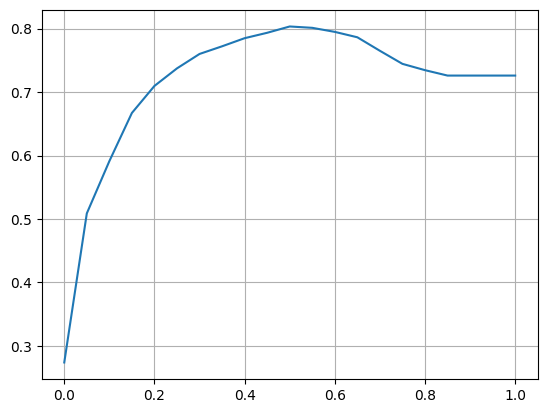

In [286]:
plt.plot(thresholds, scores)
plt.grid(True)

#0.5 indeed the best threshold

In [287]:
from collections import Counter

In [288]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

for every customer it predicts non-churning (?), and the accuracy for this model, that predicts every customer is non churning, is 73% which is only 7% less than our original 0.5 threshold model accuracy

In [289]:
Counter(y_val)
#there are a lot more non churning users

Counter({np.int64(0): 1023, np.int64(1): 386})

In [290]:
1 - y_val.mean() #non-churning percentage

np.float64(0.7260468417317246)

CLASS IMBALANCE 3:1, this is a case where accuracy can be quite a misleading score

### Confusion Table

- Different types of errors and correct decisions our model makes
- Arranging them in a table for better interpretation (confusion matrix)

Four groups: 
- true positive: y_pred >= t, y=1
- true negative: y_pred < t, y=0
- false positive: y_pred >= t, y=0
- false negative: y_pred < t, y=1

In [291]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [292]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [293]:
tp = (predict_positive & actual_positive).sum() # when both are true
tn = (predict_negative & actual_negative).sum() # when both are false

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [294]:
print("\ntp:", tp, "\ntn", tn, "\nfp:", fp, "\nfn:", fn)


tp: 210 
tn 922 
fp: 101 
fn: 176


In [295]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [296]:
(confusion_matrix / confusion_matrix.sum()).round(2) #normalize
#accuracy shown by sum of diagonal

array([[0.65, 0.07],
       [0.12, 0.15]])

### Precision and Recall

Precision tells us how many positive predictions turned out to be correct (fraction of positive correct predictions)

Precision = TP / total P = TP / (TP + FP)

In [297]:
p = tp / (tp + fp)
print("precision: ", round(100*p, 0))
p

precision:  68.0


np.float64(0.6752411575562701)

Recall is the fraction of correctly identified positive examples. How many of the churners were correctly identified.

Recall = TP / all churners = TP / (TP + FN)

In [298]:
r = tp / (tp + fn)
print("recall: ", round(100*r, 0))
r

recall:  54.0


np.float64(0.5440414507772021)

--> we failed to identify 1 - 0.54 = 46% of churners, so they didn't receive a promotional email that could have prevented them from churning.

### ROC Curves

ROC = Receiver Operating Characteristics

For this we are interested in false positive rate (FPR) and true positive rate (TPR) which we can get from confusion matrix

FPR = fraction of positives in negative examples = FP / (TN + FP)  -- we want this to be as small as possible (minimise false predictions)

TPR = fraction of positive in positive examples = TP / (FN + TP) -- we want this to be as large as possitlbe

In [299]:
fpr = fp / (tn + fp)
tpr = tp / (fn + tp)

Note: tpr = r

In [300]:
print("\nFPR: ", round(fpr, 3), "\nTPR: ", round(tpr, 3))


FPR:  0.099 
TPR:  0.544


In [301]:
thresholds = np.linspace(0, 1, 101)
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum() # when both are true
    tn = (predict_negative & actual_negative).sum() # when both are false

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [302]:
columns = ['threshold',  'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [303]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,75,20,311,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [304]:
df_scores['tpr'] = df_scores.tp / (df_scores.fn + df_scores.tp)
df_scores['fpr'] = df_scores.fpr = df_scores.fp / (df_scores.tn + df_scores.fp)

In [305]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,75,20,311,1003,0.194301,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


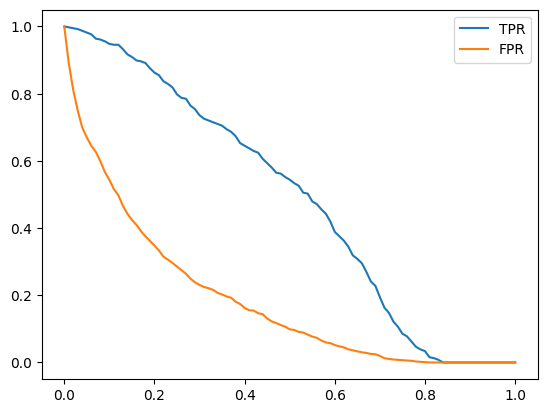

In [306]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')
plt.legend()

### Random Model

In [307]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [308]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [309]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [310]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [311]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


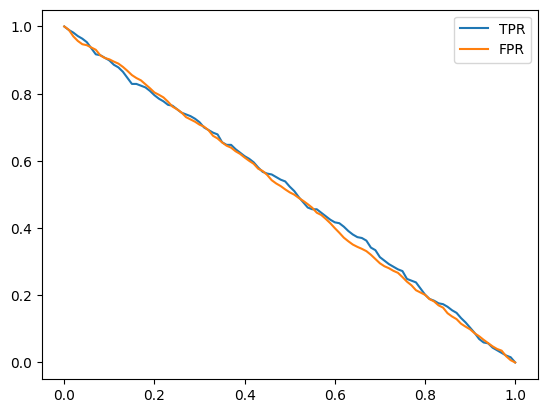

In [312]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal Model

In [313]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [314]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
print(y_ideal)

y_ideal_pred = np.linspace(0, 1, len(y_val))

[0 0 0 ... 1 1 1]


In [315]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [316]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [317]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


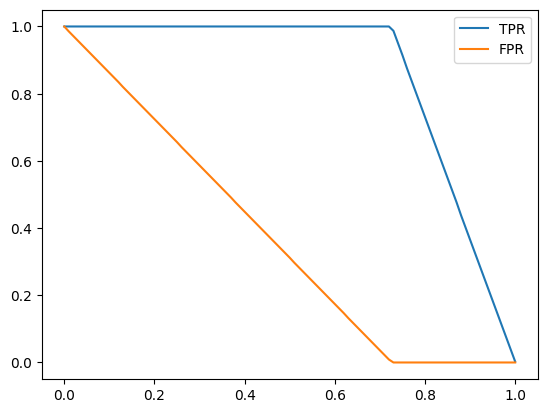

In [318]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting Everything Together

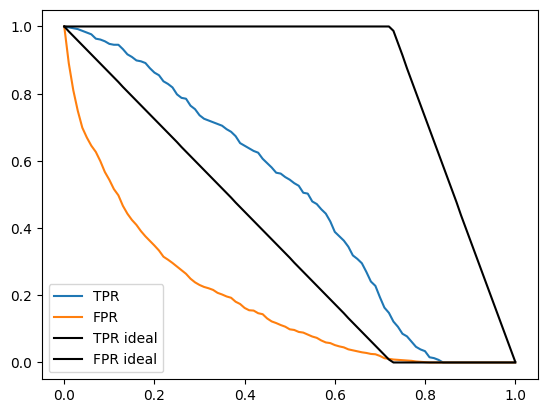

In [319]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal', color='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal', color='black')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

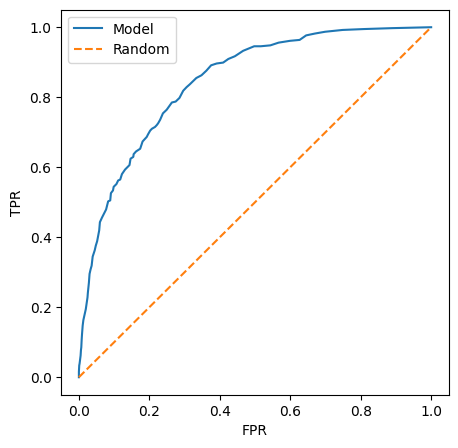

In [320]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [321]:
from sklearn.metrics import roc_curve

In [322]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

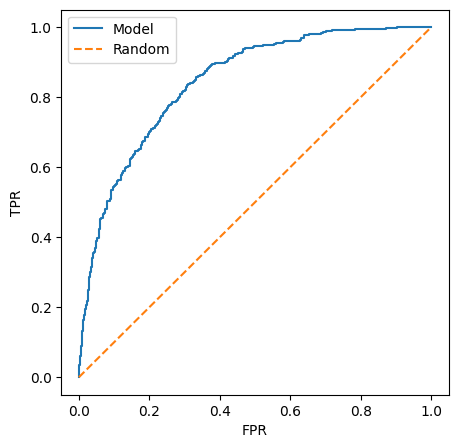

In [323]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### ROC AUC

AUC: Area under ROC curve
We want to be as close to the ideal curve as possible (ideal point at (0.0, 1,9))

The larger the AUC, the better the model

Ideal model has AUC = 1.0

AUC = 0.6 -> "Poor"
AUC = 0.8 -> "Good"
AUC = 0.9 -> "Great"
AUC < 0.5 -> Something went wrong (worse than random)

In [324]:
from sklearn.metrics import auc

In [325]:
auc(fpr, tpr) #more thresholds than our method (below)

0.8438454408703447

In [326]:
auc(df_scores.fpr, df_scores.tpr)

0.8437909936739956

In [327]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [328]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438454408703447

In [329]:
from sklearn.metrics import roc_auc_score

In [330]:
roc_auc_score(y_val, y_pred)

0.8438454408703447

In [331]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [332]:
import random

In [333]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.84412

In [334]:
n = 100000
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84295)

### Cross-Validation

- A way of evaluating the same model on different subsets of the data
- Getting the average prediction and the spread within predictions
- Parameter tuning: 

- K-fold cross valitation: split dataset into K parts and train and evaluate model on these. Then you "scramble" which part the dataset is trained and validated on:

TRAIN[1, 2] -> VALIDATION[3] -> AUC_1
TRAIN[1, 3] -> VALIDATION[2] -> AUC_2
TRAIN[2, 3] -> VALIDATION[1] -> AUC_3

mean of AUC's and std dev (which will show us how stable thhe model is)

The parts (1, 2, 3) are called "folds"


In [345]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [336]:
dv, model = train(df_train, y_train, C=0.001)

In [337]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient = 'records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [338]:
y_pred = predict(df_val, dv, model)

In [339]:
from sklearn.model_selection import KFold

In [340]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [341]:
!pip install tqdm

In [342]:
from tqdm.auto import tqdm

In [347]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):

    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

C=0.01 0.840 +- 0.008


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

C=0.1 0.842 +- 0.007


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

C=0.5 0.842 +- 0.007


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

C=1 0.842 +- 0.007


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

C=5 0.842 +- 0.007


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

C=10 0.842 +- 0.007


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [348]:
scores

[0.8445612327401464,
 0.8450846742153357,
 0.8333172787477423,
 0.8348048698599475,
 0.8519265162687082]

In [346]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8583517501381259

##### When to use cross-validation?

If your dataset is smaller, or you want to understand how std dev varies across different folds, then using cross-validation is useful.

For smaller sets you can do n_splits=10 and bigger ones only need 3

Otherwise you can just stick to normal holdout dataset.

### Summary
- Metric - a single number that describes the performance of a model
- Accuracy - fraction of correct answers; sometimes misleading
- Precision and recall are less misleading when we have class inbalance
- ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
- K-Fold CV - more reliable estimate for performance (mean + std)

### Explore more

- Check the precision and recall of the dummy classifier that always predict "FALSE"
- F1 score = 2 * P * R / (P + R)
- Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
- Area under the PR curve is also a useful metric

Other projects:
- Calculate the metrics for datasets from the previous week